In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

train_dir = r"C:\Users\gokul\Face Emotion Recognition\data\train"

In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode="grayscale",
    batch_size=32,     # ✅ safe batch size
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [4]:
labels = train_gen.classes
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.0266404434114071), 1: np.float64(9.401555464592715), 2: np.float64(1.0009587727708533), 3: np.float64(0.5684585684585685), 4: np.float64(0.826068191627104), 5: np.float64(0.8491570541259982), 6: np.float64(1.2933160650937552)}


In [5]:
model = Sequential([

    # Block 1
    Conv2D(32, (3,3), activation="relu", input_shape=(48,48,1), padding="same"),
    BatchNormalization(),
    Conv2D(32, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    Conv2D(64, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    Conv2D(128, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    # Fully Connected
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation="softmax")
])

c:\Users\gokul\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.compile(
    optimizer=Adam(learning_rate=0.0005), 
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [7]:
early_stop = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

In [8]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

c:\Users\gokul\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 746s 1s/step - accuracy: 0.1180 - loss: 2.0436 - val_accuracy: 0.1630 - val_loss: 1.9455 - learning_rate: 5.0000e-04
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 228s 318ms/step - accuracy: 0.0965 - loss: 1.9482 - val_accuracy: 0.1463 - val_loss: 1.9378 - learning_rate: 5.0000e-04
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 170s 237ms/step - accuracy: 0.1444 - loss: 1.9338 - val_accuracy: 0.2790 - val_loss: 1.9180 - learning_rate: 5.0000e-04
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 101s 140ms/step - accuracy: 0.2353 - loss: 1.9227 - val_accuracy: 0.2411 - val_loss: 1.8826 - learning_rate: 5.0000e-04
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 124s 173ms/step - accuracy: 0.2269 - loss: 1.9104 - val_accuracy: 0.2294 - val_loss: 1.8958 - learning_rate: 5.0000e-04
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 127s 177ms/step - accuracy: 0.2199 - loss: 1.8930 - val_accuracy: 0.1528 - val_loss: 1.8640 - learning_rate: 5.0000e-04
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 93s

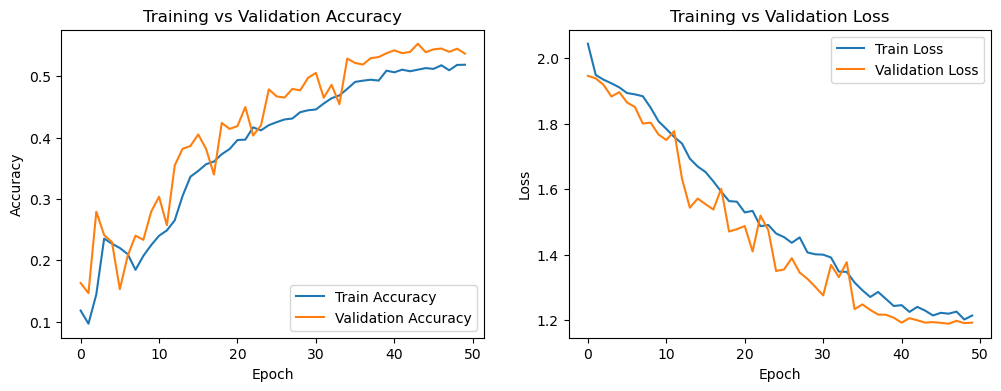

In [10]:
import matplotlib.pyplot as plt

# Extract history values
train_acc = history.history['accuracy']
val_acc   = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
ax[0].plot(train_acc, label='Train Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].set_title('Training vs Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right')

# Loss plot
ax[1].plot(train_loss, label='Train Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].set_title('Training vs Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right')

plt.show()


In [11]:
model.save("face_emotion_model.h5")
print("✅ Training complete. Model saved as face_emotion_model.h5")


✅ Training complete. Model saved as face_emotion_model.h5
